In [10]:
from glob import glob
from time import time
import os, cv2, copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from reader import readShortVideo, getVideoList
from utils import showFrames

# 1. import the table contains video and label info.

In [ ]:
task = 'train'
path = './hw4_data/TrimmedVideos/'

train_table = pd.read_csv(os.path.join(path,'label/gt_'+task+'.csv'))
train_table.head(3)

In [ ]:
train_table.count()

# 2. load training data and label

In [ ]:
# train data
video_path = './hw4_data/TrimmedVideos/video/'+task+'/'
train_x = []
train_y = []

for idx, value in train_table[['Video_category', 'Video_name', 'Action_labels']].iterrows() :
    
    video_category = value.Video_category
    video_name = value.Video_name

    def custom_VideoNameExtractor(video_path, video_category, video_name):
        video_name = glob(os.path.join(video_path, video_category, video_name)+'*')[0]
        video_name = video_name.split('/')[-1]
        return video_name
    video_name = custom_VideoNameExtractor(video_path, video_category, video_name)
    
    try:
        
        frames =  readShortVideo(video_path=video_path, 
                                 video_category=video_category, 
                                 video_name = video_name)
        train_x.append(frames / 255)
        train_y.append(value.Action_labels)
    except Exception as e:
        print(e)
        
    if (idx+1) % 100 == 0 :
        print("[INFO] loading progress, (%s/%s)" % ((idx+1), len(train_table)))
    
    
print("[INFO] load train_x successfully, train_x length :", len(train_x))

# load pretrained model

In [ ]:
import torch
from torch.autograd import Variable
from torch import nn
from torch import optim

In [ ]:
# Multi Frame VGG model
class MFVGG(nn.Module):
    def __init__(self, backend='vgg16', pretrained=True, n_label=11):
        super(MFVGG, self).__init__()
        
        ### check valid 
        if backend in ['vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn']:
            pass
        else :
            print("[INFO] invalid backend '%s', change to 'vgg16_bn'" % backend)
            backend = 'vgg16_bn'
        
        ### init param
        self.backend = backend
        self.pretrained = pretrained
        # model flow
        self.features = None
        self.avgpool = None
        self.classifier = None
        self.outLayer = None # customize output for task : Linear(1000, 11)
        
        ### init process
        self.load_pretrained() # load features
        self.create_classifier(n_label) # create last layer
#         self.fix_features() # fix features weights
        
    def forward(self, input):
        '''
        input shape : (frame, channel, height, weight)
        output shape : (1, cls)
        '''
        f, c, h, w = input.shape
        
        # regard f:frames as b:batch
        x = self.features(input) # shape : (f, 512, 7, 10)
        x = self.avgpool(x) # shape (f, 512, 7, 7)      
        
        x = torch.flatten(x, start_dim=1) # (f, 25088)
        x = torch.mean(x, 0, keepdim=True) # (1, 25088)
        
        x = self.classifier(x) # out shape : (1, 11)
        
        return x
    
    def load_pretrained(self):
        import torchvision.models as models
        backend_model = None
        try:
            if self.backend == 'vgg13' :
                backend_model = models.vgg13(pretrained=self.pretrained)
            elif self.backend == 'vgg13_bn' :
                backend_model = models.vgg13_bn(pretrained=self.pretrained)
            elif self.backend == 'vgg16' :
                backend_model = models.vgg16(pretrained=self.pretrained)
            elif self.backend == 'vgg16_bn':
                backend_model = models.vgg16_bn(pretrained=self.pretrained)
            
            
            else :
                raise ValueError("[ERROR] Unexpected backend name pass through previous check then into load_pretrained() .")
            # copy features flow
            self.features = copy.deepcopy(backend_model.features) 
            self.avgpool = copy.deepcopy(backend_model.avgpool)
            print("[INFO] load pretrained features successfully, backend : %s" % self.backend)
        except Exception as e:
            print(e)
                    
    def create_classifier(self, n_label=11):
        try:
            if self.backend in ['vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn'] :
                self.classifier = nn.Sequential(
                    nn.Linear(25088, 4096),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.5),
                    nn.Linear(4096, 4096),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.5),
                    nn.Linear(4096, 1000),
                    nn.Linear(1000, 11),
                    nn.Softmax(),
                )
            else :
                raise ValueError("[ERROR] Unexpected backend name pass through previous check then into create_outLayer() .")
        except Exception as e:
            print(e)
                
    def fix_features(self): # fix features weights
        for param in self.features.parameters():
            param.requires_grad = False


model = MFVGG(backend='vgg13_bn', pretrained=False)
            

# train model

In [ ]:
# GPU is useless when batch size = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torch import FloatTensor, LongTensor


epochs = 300
lr=1e-4

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.classifier.parameters(), lr=lr)
model.to(device)


#################### history ####################
history = {}
history['loss'] = []
history['acc'] = []

history['err'] = {}
history['err']['epoch'] = []
history['err']['err_idx'] = []
history['err']['err_msg'] = []
#################################################


for epoch in range(epochs):
    start_time = time()
    total_loss = 0.
    acc = 0.
    cnt = 0
    
    for idx, (x, y) in enumerate(zip(train_x, train_y)):
        x = np.transpose(x, (0,3,1,2)) # transpose for torch input : shape (f, 240, 320, 3) --> (f, 3, 240, 320)
        y = np.array([y]) # shape (1,)
        
        try: 
            x = Variable(FloatTensor(x)).to(device)
            y = Variable(LongTensor(y)).to(device)
        
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            
            acc += 1. if pred.argmax().item() == y.item() else 0.
            total_loss += loss.item()
            cnt += 1
        except Exception as e:
            history['err']['epoch'].append(epoch)
            history['err']['err_idx'].append(idx)
            history['err']['err_msg'].append(str(e))

    history['loss'].append(total_loss/cnt)
    history['acc'].append((100*acc)/cnt)
    print('[INFO] epoch (%d/%d), cost: %d sec | loss : %.6f | acc : %.2f%%' % (epoch, epochs, (time()-start_time), (total_loss/cnt), ((100*acc)/cnt)))


In [ ]:
from torch import FloatTensor, LongTensor
model.eval()
for idx, x in enumerate(train_x):
    x = np.transpose(x, (0,3,1,2))
    x = Variable(FloatTensor(x))
    pred = model(x).argmax().item()
    print(pred)
    break

In [ ]:
torch.save(model.classifier.state_dict(), './storage/MFVGG_classifier.pkl')

In [ ]:
cnt = 0
for x in train_x:
    if x.shape[0] <= 2 :
        print(x.shape)
        cnt += 1

In [ ]:
import pickle


with open('./storage/history_p1_avgpool_MFVGG_epoch160', 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# valid & report

### 2. Report your video recognition performance (valid) using CNN-based video features and make your code reproduce this result. (5%)

In [4]:
import pandas as pd
import numpy as np
import os


In [ ]:
# load label
task = 'valid'
path = './hw4_data/TrimmedVideos/'

table = pd.read_csv(os.path.join(path,'label/gt_'+task+'.csv'))
label = table['Action_labels']
len(label)


# load pred
pred = []
with open('./output/p1_valid.txt', 'r') as file:
    for line in file:
        pred.append(int(line.replace('\n','')))
len(pred)

# eval
(np.array(label) == np.array(pred)).sum() / len(pred)

In [ ]:
## import pickle

history = None
with open('./storage/history_p1_avgpool_MFVGG_epoch160', 'rb') as file:
    history = pickle.load(file)
    
    
    
# plot loss and acc
loss = history['loss']
# acc = history['acc']
acc = np.array(acc)
acc += 0.11

x = np.arange(len(loss))

plt.plot(x, loss)
# plt.plot(x, acc)

plt.legend(['loss'], loc='upper right')
plt.show()

### 3. Visualize CNN-based video features to 2D space (with tSNE) in your report. You need to color them with respect to different action labels. (10%)

In [20]:
task = 'valid'
path = './hw4_data/TrimmedVideos/'

train_table = pd.read_csv(os.path.join(path,'label/gt_'+task+'.csv'))
train_table.head(3)


video_path = './hw4_data/TrimmedVideos/video/'+task+'/'
train_x = []
train_y = []

for idx, value in train_table[['Video_category', 'Video_name', 'Action_labels']].iterrows() :
    
    video_category = value.Video_category
    video_name = value.Video_name

    def custom_VideoNameExtractor(video_path, video_category, video_name):
        video_name = glob(os.path.join(video_path, video_category, video_name)+'*')[0]
        video_name = video_name.split('/')[-1]
        return video_name
    video_name = custom_VideoNameExtractor(video_path, video_category, video_name)
    
    try:
        
        frames =  readShortVideo(video_path=video_path, 
                                 video_category=video_category, 
                                 video_name = video_name)
        train_x.append(frames / 255)
        train_y.append(value.Action_labels)
    except Exception as e:
        print(e)
        
    if (idx+1) % 100 == 0 :
        print("[INFO] loading progress, (%s/%s)" % ((idx+1), len(train_table)))
    
print("[INFO] load train_x successfully, train_x length :", len(train_x))

[INFO] loading progress, (100/769)
[INFO] loading progress, (200/769)
[INFO] loading progress, (300/769)
[INFO] loading progress, (400/769)
[INFO] loading progress, (500/769)
[INFO] loading progress, (600/769)
[INFO] loading progress, (700/769)
[INFO] load train_x successfully, train_x length : 769


In [7]:
# load model

from model.MFVGG import MFVGG
import torch
model = MFVGG(backend='vgg13_bn')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
if device == 'cuda':
    model.classifier.load_state_dict(torch.load(os.path.join('./storage/MFVGG_classifier.pkl')))
else :
    model.classifier.load_state_dict(torch.load(os.path.join('./storage/MFVGG_classifier.pkl'), map_location=lambda storage, loc: storage))

[INFO] load pretrained features successfully, backend : vgg13_bn


In [63]:
from matplotlib import pyplot as plt

from torch import FloatTensor
from torch.autograd import Variable

features = []
ys = []
model.cuda()
for idx, (x,y) in enumerate(zip(train_x, train_y)):
    try:
        x = np.transpose(x, (0,3,1,2))
        x = Variable(FloatTensor(x)).cuda()
        x = model.features(x)
        
        x = model.avgpool(x) # shape (f, 512, 7, 7)  
        x = torch.flatten(x, start_dim=1)
        x = torch.mean(x, 0, keepdim=True) # (1, 25088)
        x = torch.squeeze(x, 0) # (25088)
        
        x = x.cpu()
        features.append(torch.squeeze(x,0).detach().numpy())
        ys.append(y)
    except Exception as e:
        print(idx, e)
#     if idx > 100:
#         break



ys = np.array(ys)

23 CUDA out of memory. Tried to allocate 1.15 GiB (GPU 0; 7.93 GiB total capacity; 5.96 GiB already allocated; 287.19 MiB free; 595.74 MiB cached)
24 CUDA out of memory. Tried to allocate 63.38 MiB (GPU 0; 7.93 GiB total capacity; 6.70 GiB already allocated; 31.19 MiB free; 88.87 MiB cached)
25 CUDA out of memory. Tried to allocate 318.75 MiB (GPU 0; 7.93 GiB total capacity; 6.05 GiB already allocated; 287.19 MiB free; 499.24 MiB cached)
60 CUDA out of memory. Tried to allocate 1.12 GiB (GPU 0; 7.93 GiB total capacity; 5.85 GiB already allocated; 287.19 MiB free; 709.99 MiB cached)
90 CUDA out of memory. Tried to allocate 63.38 MiB (GPU 0; 7.93 GiB total capacity; 6.70 GiB already allocated; 31.19 MiB free; 88.87 MiB cached)
109 CUDA out of memory. Tried to allocate 309.38 MiB (GPU 0; 7.93 GiB total capacity; 6.25 GiB already allocated; 287.19 MiB free; 298.49 MiB cached)
111 CUDA out of memory. Tried to allocate 145.38 MiB (GPU 0; 7.93 GiB total capacity; 6.51 GiB already allocated; 1

598 CUDA out of memory. Tried to allocate 675.00 MiB (GPU 0; 7.93 GiB total capacity; 5.31 GiB already allocated; 297.19 MiB free; 1.22 GiB cached)
610 CUDA out of memory. Tried to allocate 900.00 MiB (GPU 0; 7.93 GiB total capacity; 5.10 GiB already allocated; 297.19 MiB free; 1.43 GiB cached)
613 CUDA out of memory. Tried to allocate 262.50 MiB (GPU 0; 7.93 GiB total capacity; 6.28 GiB already allocated; 33.19 MiB free; 523.37 MiB cached)
646 CUDA out of memory. Tried to allocate 112.50 MiB (GPU 0; 7.93 GiB total capacity; 6.56 GiB already allocated; 33.19 MiB free; 226.87 MiB cached)
651 CUDA out of memory. Tried to allocate 1012.50 MiB (GPU 0; 7.93 GiB total capacity; 5.33 GiB already allocated; 297.19 MiB free; 1.20 GiB cached)
681 CUDA out of memory. Tried to allocate 1.39 GiB (GPU 0; 7.93 GiB total capacity; 4.76 GiB already allocated; 347.19 MiB free; 1.72 GiB cached)
682 CUDA out of memory. Tried to allocate 49.25 MiB (GPU 0; 7.93 GiB total capacity; 6.66 GiB already allocated

In [64]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


features = np.array(features)
X_embedded = PCA(n_components=100).fit_transform(features)
X_embedded = TSNE(n_components=2).fit_transform(X_embedded)
X_embedded.shape

(699, 2)

10 list index out of range


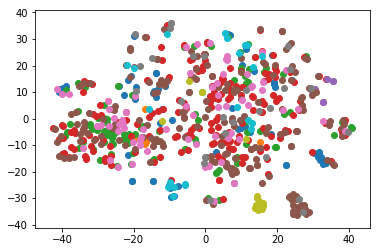

In [65]:
# cmap = [
#             'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
#             'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']
cmap = ['C0','C1','C2','C3','C4','C5', 'C6','C7','C8','C9']

for label in range(0,11):
    try:
        selected_data = X_embedded[np.where(ys == label)]
        plt.scatter(selected_data[:,0], selected_data[:,1], c=cmap[label])
    except Exception as e:
        print(label, e)
plt.show()


In [52]:
cmap[10]

0.9367421586151258

In [46]:
selected_data[:,0].shape

(30,)

In [40]:
selected_data[:,0].shape

(70,)

In [36]:
np.where(ys == label)

(array([107, 109, 113, 137, 142, 143, 147, 165, 169, 172, 174, 175, 176,
        177, 178, 179, 180, 204, 215, 270, 302, 303, 309, 315, 318, 356,
        367, 371, 375, 386, 389, 390, 392, 393, 395, 417, 424, 426, 429,
        442, 454, 475, 477, 480, 489, 497, 503, 510, 524, 535, 549, 552,
        555, 572, 582, 583, 593, 617, 624, 643, 644, 653, 659, 683, 689,
        702, 703, 704, 706, 732]),)